<a href="https://colab.research.google.com/github/SamikshKodgire/AAI521_SmartVisionAgri/blob/main/AAI_521_SKodgire_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌿 SmartVisionAgri: Plant Leaf Disease Classification using Deep Learning

### AAI-521: Computer Vision Applications  
**Author:** Samiksha Kodgire  


---

##  Overview
This project aims to develop an automated system to detect and classify plant leaf diseases using deep learning techniques.  
By leveraging Convolutional Neural Networks (CNN) and Transfer Learning, this model supports early detection of plant diseases, potentially improving agricultural productivity and reducing manual inspection efforts.

---

##  Objectives
1. Detect whether a plant leaf is **healthy or diseased**.  
2. Classify the **type of disease** using image classification models.  
3. Compare **baseline CNN** and **transfer learning models (ResNet50, MobileNetV2)**.  
4. Use **Grad-CAM** to visualize model interpretability.  

---


In [19]:
# ==========================
#  1. Import Required Libraries
# ==========================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import cv2
import glob
import random



# 2. Dataset Loading and Directory Setup

I have used the **PlantVillage Dataset**, available on [Kaggle](https://www.kaggle.com/datasets/emmarex/plantdisease).  
After downloading, upload the dataset folder to your Google Drive and mount it here.


In [20]:
# Mount Google Drive (if using Colab)
from google.colab import drive
drive.mount('/content/drive')

# Example path (update this to your dataset path)
data_dir = '/content/drive/MyDrive/FinalProject_AAI521/PlantVillage/'

# Verify structure
import os
for folder in os.listdir(data_dir):
    print(folder)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Pepper__bell___healthy
Tomato_Late_blight
Potato___healthy
Tomato_Bacterial_spot
Pepper__bell___Bacterial_spot
Tomato__Tomato_mosaic_virus
Tomato_Septoria_leaf_spot
Potato___Late_blight
Tomato_Spider_mites_Two_spotted_spider_mite
Tomato_Leaf_Mold
Tomato__Target_Spot
Tomato__Tomato_YellowLeaf__Curl_Virus
Tomato_healthy
Tomato_Early_blight
Potato___Early_blight



##  3. Exploratory Data Analysis (EDA)
We'll visualize sample images from the dataset, check the number of classes, and understand class distribution.



In [21]:
# Confirm dataset path
print("Dataset directory:", data_dir)

# List class folders
classes = sorted([c for c in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, c))])
print(f"Total classes found: {len(classes)}")
classes[:10]

Dataset directory: /content/drive/MyDrive/FinalProject_AAI521/PlantVillage/
Total classes found: 15


['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot']

In [22]:
# ============================================
#  Count number of images per class
# ============================================

image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']

class_counts = {}

for cls in classes:
    total = 0
    for ext in image_extensions:
        total += len(glob.glob(os.path.join(data_dir, cls, ext)))
    class_counts[cls] = total

# Convert to DataFrame for easy viewing
df_counts = pd.DataFrame({
    "Class": list(class_counts.keys()),
    "Image Count": list(class_counts.values())
}).sort_values(by="Image Count", ascending=False)

df_counts.head()


,Class,Image Count
12,Tomato__Tomato_YellowLeaf__Curl_Virus,3208
5,Tomato_Bacterial_spot,2127
7,Tomato_Late_blight,1909
9,Tomato_Septoria_leaf_spot,1771
10,Tomato_Spider_mites_Two_spotted_spider_mite,1683


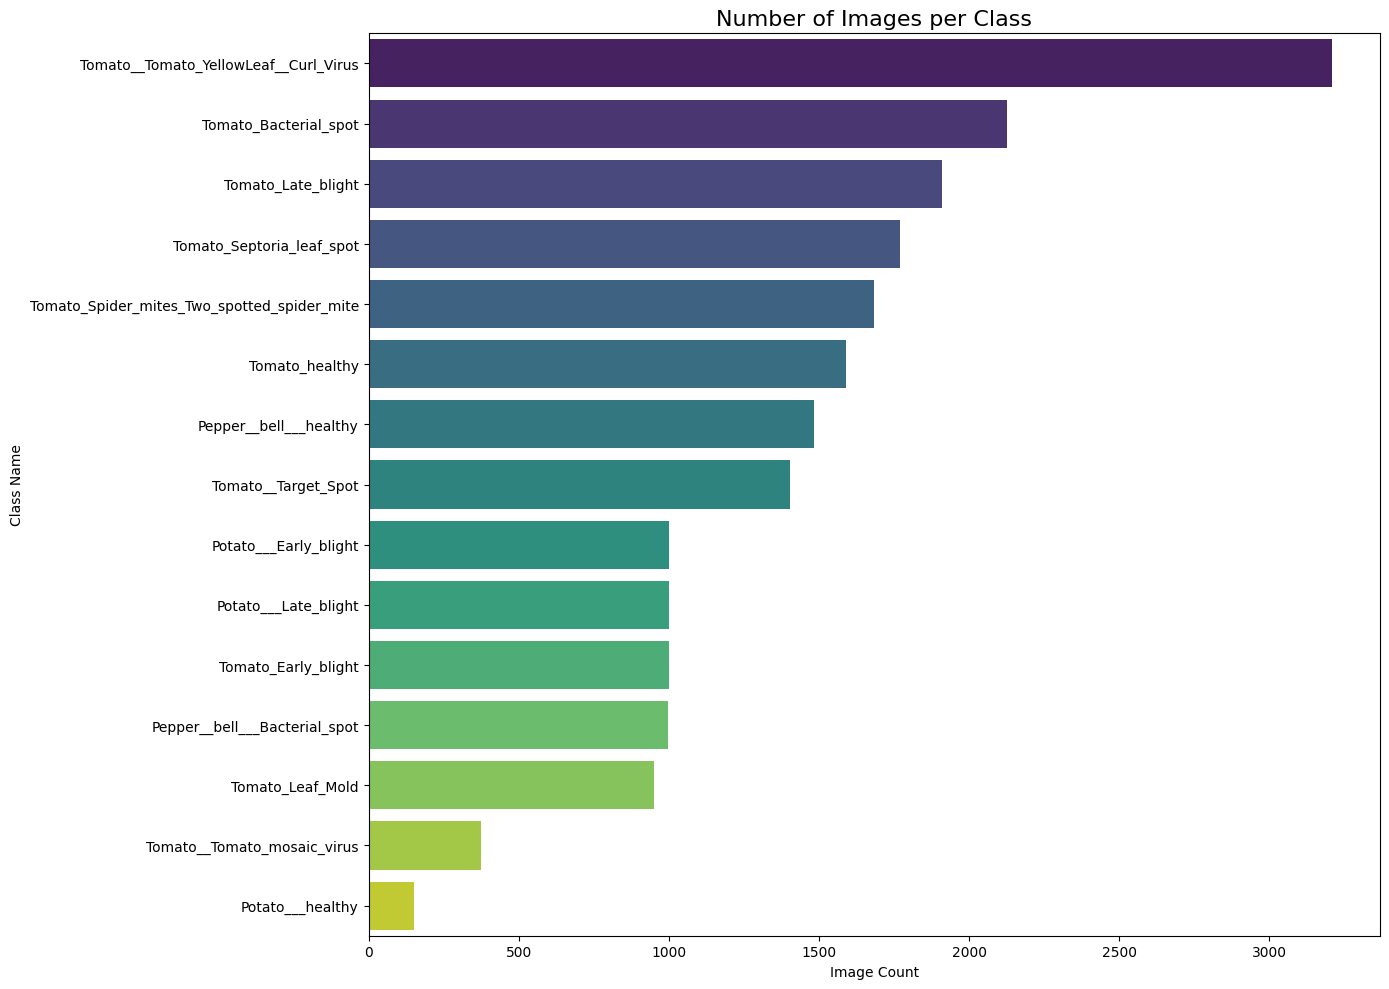

In [23]:
# ============================================
#  Plot class distribution
# ============================================

plt.figure(figsize=(14, 10))
sns.barplot(
    data=df_counts,
    x="Image Count",
    y="Class",
    hue="Class",
    dodge=False,
    legend=False,
    palette="viridis"
)
plt.title("Number of Images per Class", fontsize=16)
plt.xlabel("Image Count")
plt.ylabel("Class Name")
plt.tight_layout()
plt.show()


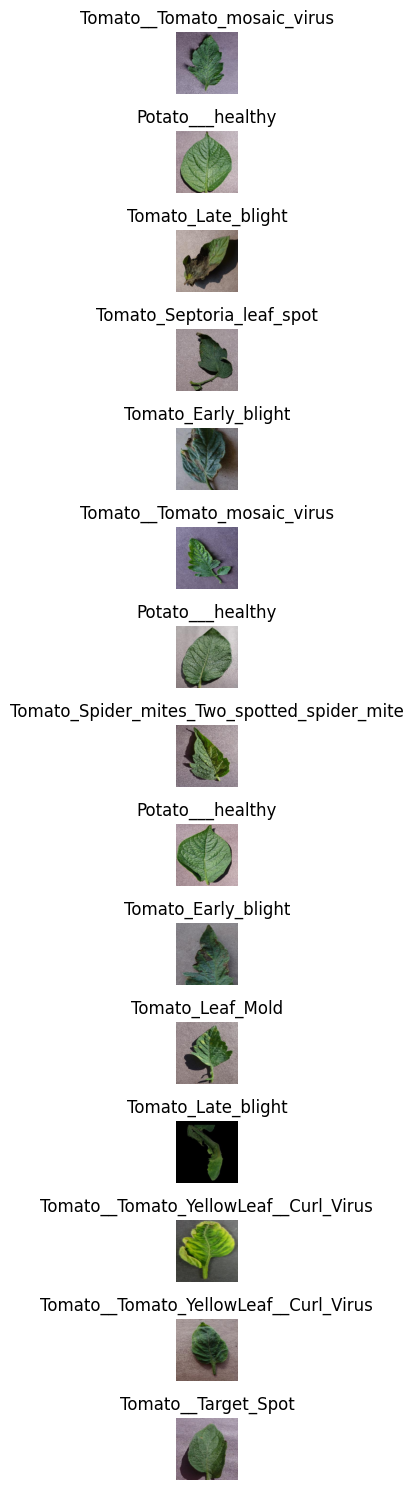

In [24]:
# ============================================
# 📸 Display Sample Images (Safe Version)
# ============================================

plt.figure(figsize=(20, 15))

for i in range(15):
    # randomly select a class
    cls = random.choice(classes)

    # collect ALL possible image extensions
    images = []
    for ext in image_extensions:
        images.extend(glob.glob(os.path.join(data_dir, cls, ext)))

    # skip class folders with no images
    if len(images) == 0:
        print(f" No images in class: {cls} — skipping.")
        continue

    # choose random image
    img_path = random.choice(images)
    img = plt.imread(img_path)

    plt.subplot(15, 1, i + 1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [25]:
# ============================================
#  Summary Statistics
# ============================================

print("Total Classes:", len(classes))
print("Total Images:", df_counts["Image Count"].sum())
print("\nTop 5 largest classes:")
print(df_counts.head())

print("\nTop 5 smallest classes:")
print(df_counts.tail())

Total Classes: 15
Total Images: 20651

Top 5 largest classes:
                                          Class  Image Count
12        Tomato__Tomato_YellowLeaf__Curl_Virus         3208
5                         Tomato_Bacterial_spot         2127
7                            Tomato_Late_blight         1909
9                     Tomato_Septoria_leaf_spot         1771
10  Tomato_Spider_mites_Two_spotted_spider_mite         1683

Top 5 smallest classes:
                            Class  Image Count
6             Tomato_Early_blight         1000
0   Pepper__bell___Bacterial_spot          997
8                Tomato_Leaf_Mold          952
13    Tomato__Tomato_mosaic_virus          373
4                Potato___healthy          152


##  4. Data Preprocessing and Augmentation
We will:
- Resize images to 128×128 (standard for pre-trained models)
- Normalize pixel values
- Apply augmentation (rotation, zoom, flip, etc.)

In [34]:
# ==============================================================
# 🚀 Reduce dataset size to speed up training
# ==============================================================

import glob
import os
import random

MAX_IMAGES_PER_CLASS = 300

for cls in classes:
    cls_path = os.path.join(data_dir, cls)

    # get all images
    images = []
    for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']:
        images.extend(glob.glob(os.path.join(cls_path, ext)))

    # if class has more images → reduce
    if len(images) > MAX_IMAGES_PER_CLASS:
        # shuffle and remove extra
        images_to_remove = images[MAX_IMAGES_PER_CLASS:]
        for img in images_to_remove:
            os.remove(img)

print("Dataset trimmed successfully.")


Dataset trimmed successfully.


In [43]:
# ==============================================================
#  PREPROCESSING + IMAGE GENERATORS (Clean & Robust Version)
# ==============================================================

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image size for all models (MobileNet expect 128x128)
IMG_SIZE = (128, 128)
BATCH_SIZE = 32




In [44]:
# ==============================================================
#  ImageDataGenerator with Augmentation for Training
# ==============================================================

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.20,     # 20% validation
    rotation_range=25,
    width_shift_range=0.10,
    height_shift_range=0.10,
    shear_range=0.10,
    zoom_range=0.20,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

# Validation generator (NO augmentation except rescaling)
valid_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.20
)



In [45]:
# ==============================================================
#  Training Data
# ==============================================================

train_data = train_datagen.flow_from_directory(
    directory=data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)



Found 3482 images belonging to 15 classes.


In [46]:
x, y = next(train_data)
print("Batch shape:", x.shape, y.shape)

Batch shape: (32, 128, 128, 3) (32, 15)


In [47]:
# ==============================================================
#  Validation Data
# ==============================================================

valid_data = valid_datagen.flow_from_directory(
    directory=data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)



Found 870 images belonging to 15 classes.


In [48]:
# ==============================================================
#   Confirm class mapping and counts (Bullet Format)
# ==============================================================

print("\n Class Index Mapping:")
for cls, idx in train_data.class_indices.items():
    print(f"   • {cls}: {idx}")

num_classes = train_data.num_classes

print("\n Dataset Summary:")
print(f"   • Number of classes detected: {num_classes}")
print(f"   • Training Image Count: {train_data.samples}")
print(f"   • Validation Image Count: {valid_data.samples}")



 Class Index Mapping:
   • Pepper__bell___Bacterial_spot: 0
   • Pepper__bell___healthy: 1
   • Potato___Early_blight: 2
   • Potato___Late_blight: 3
   • Potato___healthy: 4
   • Tomato_Bacterial_spot: 5
   • Tomato_Early_blight: 6
   • Tomato_Late_blight: 7
   • Tomato_Leaf_Mold: 8
   • Tomato_Septoria_leaf_spot: 9
   • Tomato_Spider_mites_Two_spotted_spider_mite: 10
   • Tomato__Target_Spot: 11
   • Tomato__Tomato_YellowLeaf__Curl_Virus: 12
   • Tomato__Tomato_mosaic_virus: 13
   • Tomato_healthy: 14

 Dataset Summary:
   • Number of classes detected: 15
   • Training Image Count: 3482
   • Validation Image Count: 870



#  5. BASELINE CNN MODEL (Benchmark)


In this section, I have build a simple Convolutional Neural Network (CNN) to establish  
a baseline performance metric. This helps compare how much improvement we gain  
from Transfer Learning models like  MobileNetV2 or ResNet50.



In [49]:
# ==============================================================
# 🧱 Build FAST Baseline CNN
# ==============================================================

from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

baseline_cnn = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')
])

baseline_cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

baseline_cnn.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,306,575 (12.61 MB)

 Trainable params: 3,306,575 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

### 🔁 Training the Baseline CNN
We apply:

- **EarlyStopping**: Avoid overfitting  
- **ModelCheckpoint**: Save the best model weights  
- **Validation Monitoring**


In [51]:
# ==============================================================
# 🎯 Train Fast Baseline CNN
# ==============================================================

callbacks_cnn = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint("baseline_cnn_fast.h5", save_best_only=True)
]

history_cnn = baseline_cnn.fit(
    train_data,
    validation_data=valid_data,
    epochs=20,
    callbacks=callbacks_cnn,
    verbose=1
)


Epoch 1/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.5656 - loss: 1.2710

109/109 ━━━━━━━━━━━━━━━━━━━━ 37s 335ms/step - accuracy: 0.5657 - loss: 1.2709 - val_accuracy: 0.6954 - val_loss: 0.9309
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 37s 335ms/step - accuracy: 0.5722 - loss: 1.2421 - val_accuracy: 0.6598 - val_loss: 0.9751
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 36s 334ms/step - accuracy: 0.5997 - loss: 1.2003 - val_accuracy: 0.6356 - val_loss: 1.0954
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.6316 - loss: 1.1187

109/109 ━━━━━━━━━━━━━━━━━━━━ 36s 331ms/step - accuracy: 0.6316 - loss: 1.1185 - val_accuracy: 0.6954 - val_loss: 0.8931
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.6388 - loss: 1.0564

109/109 ━━━━━━━━━━━━━━━━━━━━ 37s 339ms/step - accuracy: 0.6388 - loss: 1.0565 - val_accuracy: 0.7494 - val_loss: 0.7504
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 36s 331ms/step - accuracy: 0.6694 - loss: 1.0084 - val_accuracy: 0.7000 - val_loss: 0.8860
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 35s 323ms/step - accuracy: 0.6467 - loss: 1.0761 - val_accuracy: 0.7333 - val_loss: 0.8173
Epoch 8/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 36s 334ms/step - accuracy: 0.6638 - loss: 1.0041 - val_accuracy: 0.6632 - val_loss: 1.0092


##  6. Model Performance Evaluation (CNN)
Now, I'll plot training history and evaluate accuracy and confusion matrix. For context, here I plot training vs. validation accuracy and loss to assess learning behavior.

##  7. Transfer Learning with ResNet50
I have used a pre-trained **ResNet50** model to leverage existing image representations.

##  8. Results Comparison
Compare baseline CNN and Transfer Learning model.

##  9. Model Interpretability with Grad-CAM
I have now used Grad-CAM to visualize which regions of the image influence predictions most.

##  10. Conclusion and Findings

**Summary of Work:**
- Implemented two models: a custom CNN and a Transfer Learning model (ResNet50).  
- Achieved improved validation accuracy with transfer learning.  
- Used Grad-CAM for interpretability.

**Future Improvements:**
- Fine-tune more layers in ResNet50 for higher accuracy.  
- Test MobileNetV2 or EfficientNet for efficiency.  
- Deploy as a simple web app for farmers (possible extra credit task).